<a href="https://colab.research.google.com/github/VVdovichev/PyTorch_GB/blob/main/HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:
###изменение слоёв и их количества;
###изменение метода оптимизации;
###изменение процесса обучения;
###*преобразование данных transform

In [146]:
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [147]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print(image.size())
print(label)

Files already downloaded and verified
torch.Size([3, 32, 32])
6


In [148]:
image.permute(1, 2, 0).shape

torch.Size([32, 32, 3])

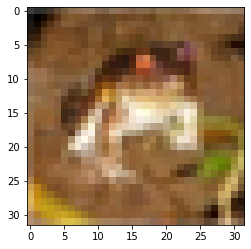

In [149]:
plt.imshow(image.permute(1, 2, 0).numpy());

In [150]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [151]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

Files already downloaded and verified


In [152]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Базовая модель.

In [153]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.softmax(x)
        return x


net = Net(3072, 100, 10)
net.train()

Net(
  (fc1): Linear(in_features=3072, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [154]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

In [155]:
%%time
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

         # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')
            running_loss, running_items = 0.0, 0.0

print('Training is finished!')

Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.036
Epoch [1/5]. Step [601/782]. Loss: 0.035
Epoch [2/5]. Step [1/782]. Loss: 0.033
Epoch [2/5]. Step [301/782]. Loss: 0.032
Epoch [2/5]. Step [601/782]. Loss: 0.031
Epoch [3/5]. Step [1/782]. Loss: 0.032
Epoch [3/5]. Step [301/782]. Loss: 0.030
Epoch [3/5]. Step [601/782]. Loss: 0.029
Epoch [4/5]. Step [1/782]. Loss: 0.030
Epoch [4/5]. Step [301/782]. Loss: 0.029
Epoch [4/5]. Step [601/782]. Loss: 0.028
Epoch [5/5]. Step [1/782]. Loss: 0.032
Epoch [5/5]. Step [301/782]. Loss: 0.028
Epoch [5/5]. Step [601/782]. Loss: 0.028
Training is finished!
CPU times: user 1min 7s, sys: 479 ms, total: 1min 8s
Wall time: 1min 8s


In [156]:
data_iter = iter(test_loader)
images, labels = data_iter.next()
net.eval()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'ship' 'ship' 'ship' 'deer' 'frog' 'dog' 'deer']
Accuracy is 0.375


##Улучшенная модель.

In [165]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 2 * hidden_dim)
        self.fc2 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x


net = Net(3072, 100, 10)
net.train()

Net(
  (fc1): Linear(in_features=3072, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [166]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [167]:
%%time
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

         # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')
            running_loss, running_items = 0.0, 0.0

Epoch [1/10]. Step [1/782]. Loss: 0.036
Epoch [1/10]. Step [301/782]. Loss: 0.031
Epoch [1/10]. Step [601/782]. Loss: 0.028
Epoch [2/10]. Step [1/782]. Loss: 0.025
Epoch [2/10]. Step [301/782]. Loss: 0.026
Epoch [2/10]. Step [601/782]. Loss: 0.026
Epoch [3/10]. Step [1/782]. Loss: 0.022
Epoch [3/10]. Step [301/782]. Loss: 0.025
Epoch [3/10]. Step [601/782]. Loss: 0.025
Epoch [4/10]. Step [1/782]. Loss: 0.023
Epoch [4/10]. Step [301/782]. Loss: 0.024
Epoch [4/10]. Step [601/782]. Loss: 0.024
Epoch [5/10]. Step [1/782]. Loss: 0.027
Epoch [5/10]. Step [301/782]. Loss: 0.023
Epoch [5/10]. Step [601/782]. Loss: 0.023
Epoch [6/10]. Step [1/782]. Loss: 0.023
Epoch [6/10]. Step [301/782]. Loss: 0.023
Epoch [6/10]. Step [601/782]. Loss: 0.023
Epoch [7/10]. Step [1/782]. Loss: 0.029
Epoch [7/10]. Step [301/782]. Loss: 0.022
Epoch [7/10]. Step [601/782]. Loss: 0.022
Epoch [8/10]. Step [1/782]. Loss: 0.022
Epoch [8/10]. Step [301/782]. Loss: 0.022
Epoch [8/10]. Step [601/782]. Loss: 0.022
Epoch [9

In [168]:
data_iter = iter(test_loader)
images, labels = data_iter.next()
net.eval()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'ship' 'ship' 'deer' 'frog' 'car' 'frog']
Accuracy is 0.75


###Улучшить модель позволило:
- уменьшение слоев,
- увеличение эпох,
- изменение метода оптимизации.